This IPython Notebook handles the training and evaluation of a neural net that produces a heatmap of edge likelihood from an unsaturated image

In [1]:
# Handle imports
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [45]:
class ImageGenerator():
    def __init__(self, shape: tuple, batchSize: int):
        self.shape = shape

    def generate_image(self) -> np.ndarray:
        shapeBGR = (self.shape[0], self.shape[1], 3)
        imageBGR = np.zeros(shapeBGR, 'uint8')
        # pick two sides
        flips = np.random.randint()
        # pick random points on lines

        # Set up polygon, draw

        # flip with P = 0.5

        pts = np.array([[0,0], [99,99], [0,99]], np.int32)
        pts = np.expand_dims(pts, 1)
        cv2.fillPoly(imageBGR, [pts], (255,255,255))

        image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

        return image



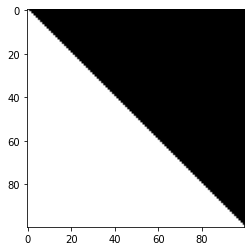

In [46]:
generator = ImageGenerator((100, 100), 1)
img = generator.generate_image()

def imshow(image: np.ndarray):
    if image.ndim == 2:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    elif image.ndim == 3:
        plt.imshow(image[:,:,::-1])
    else:
        raise(ValueError)
    plt.show()

imshow(img)

In [173]:
a = np.array([[0,0],[0,2],[1,2],[1,0],[0,0],[0,2],[1,2],[1,0]])
b = np.random.randint(0,4)
c = np.random.randint(1,4)
print(b, b+c)
a[b:b+c]

# interpolate between b and b+1, c and c+1

1 4


array([[0, 2],
       [1, 2],
       [1, 0]])